In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from numpy import column_stack

from utils.classing import get_target_by_classing
from utils.data import FilePaths, read_image_file
from utils.models import (
    albedo_polynomial_fit,
    albedo_polynomial_sharpening,
    linear_fit,
    linear_sharpening,
    multi_linear_fit,
    multi_linear_sharpening,
)
from utils.patching import get_fine_reconstruction_from_patches
from utils.residualcorrection import (
    upscale_coarse,
    upscale_coarse_krig
)

In [2]:
n_c = 30
n_h = 150

In [3]:
I_C = read_image_file(FilePaths.INDEX_C)
I_H = read_image_file(FilePaths.INDEX_H)
T_C = read_image_file(FilePaths.TEMP_C)
T_H = read_image_file(FilePaths.TEMP_H)
A_C = read_image_file(FilePaths.ALBEDO_C)
A_H = read_image_file(FilePaths.ALBEDO_H)
C_C = read_image_file(FilePaths.CLASS_C)
C_H = read_image_file(FilePaths.CLASS_H)

## Linear Fit

In [4]:
linear_fit_res = linear_fit(I_C, T_C)

linear_pred = linear_sharpening(I_C, linear_fit_res)
linear_resids = T_C - linear_pred

linear_sharp = linear_sharpening(I_H, linear_fit_res)

upscaled_linear_linear_resids = upscale_coarse(linear_resids)
upscaled_linear_krig_resids = upscale_coarse_krig(linear_resids)

linear_sharp_rc_linaer = linear_sharp + upscaled_linear_linear_resids
linear_sharp_rc_krig = linear_sharp + upscaled_linear_krig_resids

## Multi-Linear Fit

In [5]:
multi_model = multi_linear_fit([I_C, A_C], T_C)

multi_pred = multi_linear_sharpening([I_C.flatten(), A_C.flatten()], multi_model, n_c)
multi_resids = T_C - multi_pred

multi_sharp = multi_linear_sharpening([I_H.flatten(), A_H.flatten()], multi_model, n_h)

upscaled_multi_linear_resids = upscale_coarse(multi_resids)
upscaled_multi_krig_resids = upscale_coarse_krig(multi_resids)

multi_sharp_rc_linear = multi_sharp + upscaled_multi_linear_resids
multi_sharp_rc_krig = multi_sharp + upscaled_multi_krig_resids


## Polynomial Fit

In [6]:
poly_model = albedo_polynomial_fit([I_C, A_C], T_C)

poly_pred = albedo_polynomial_sharpening([I_C, A_C], poly_model, n_c)
poly_resids = T_C - poly_pred

poly_sharp = albedo_polynomial_sharpening([I_H, A_H], poly_model, n_h)

upscaled_poly_linear_resids = upscale_coarse(poly_resids)
upscaled_poly_krig_resids = upscale_coarse_krig(poly_resids)

poly_sharp_rc_linear = poly_sharp + upscaled_poly_linear_resids
poly_sharp_rc_krig = poly_sharp + upscaled_poly_krig_resids

## Patching

In [7]:
patch_size = 5
stride = patch_size
coarse_image_temp = T_C

#### Linear Patching

In [8]:
lin_coarse_inputs = [I_C]
lin_fine_inputs = [I_H]

linear_patched, linear_patched_resids = get_fine_reconstruction_from_patches(
    lin_coarse_inputs, lin_fine_inputs, coarse_image_temp, linear_fit, linear_sharpening, patch_size, stride,
)

#### Multi Linear Patching

In [9]:
multi_coarse_inputs = [I_C, A_C]
multi_fine_inputs = [I_H, A_H]

multi_patched, multi_patched_resids = get_fine_reconstruction_from_patches(
    multi_coarse_inputs, multi_fine_inputs, coarse_image_temp, multi_linear_fit, multi_linear_sharpening, patch_size, stride,
)


#### Polynomial Patching

In [10]:
poly_coarse_inputs = [I_C, A_C]
poly_fine_inputs = [I_H, A_H]

poly_patched, poly_patched_resids = get_fine_reconstruction_from_patches(
    poly_coarse_inputs, poly_fine_inputs, coarse_image_temp, albedo_polynomial_fit, albedo_polynomial_sharpening, patch_size, stride,
)

## Classing

In [11]:
coarse_image_temp = T_C

classes = np.unique(C_C)
coarse_masks = {}
fine_masks = {}

for class_ in classes:
    coarse_masks[class_] = C_C == class_
    fine_masks[class_] = C_H == class_


#### Linear Classing

In [12]:
lin_coarse_inputs = [I_C]
lin_fine_inputs = [I_H]

linear_classed, linear_classes_resids = get_target_by_classing(
    lin_coarse_inputs, lin_fine_inputs, coarse_image_temp, coarse_masks, fine_masks, linear_fit, linear_sharpening,
)

Multi Linear Classing

In [14]:
multi_coarse_inputs = [I_C, A_C]
multi_fine_inputs = [I_H, A_H]

multi_classed, multi_classes_resids = get_target_by_classing(
    multi_coarse_inputs, multi_fine_inputs, coarse_image_temp, coarse_masks, fine_masks, multi_linear_fit, multi_linear_sharpening,
)

#### Polynomial Classing

In [15]:
poly_coarse_inputs = [I_C, A_C]
poly_fine_inputs = [I_H, A_H]

poly_classed, poly_classes_resids = get_target_by_classing(
    poly_coarse_inputs, poly_fine_inputs, coarse_image_temp, coarse_masks, fine_masks,
    albedo_polynomial_fit, albedo_polynomial_sharpening,
)

In [19]:
fit_func = linear_fit
sharpening_func = linear_sharpening

coarse_inputs = [I_C]
fine_inputs = [I_H]
coarse_target = T_C
scale = 5

coarse_resids = np.zeros((n_c, n_c))
fine_target = np.zeros((n_h, n_h))

for class_ in classes:
    coarse_mask = coarse_masks[class_]
    fine_mask = fine_masks[class_]

    coarse_masked_inputs = [input[coarse_mask] for input in coarse_inputs]
    fine_masked_inputs = [input[fine_mask] for input in fine_inputs]
    coarse_masked_target = coarse_target[coarse_mask]

    fit_res = fit_func(coarse_masked_inputs, coarse_masked_target)
    fit_pred = sharpening_func(coarse_masked_inputs, fit_res, patch_size)
    coarse_resids[coarse_mask] = coarse_masked_target - fit_pred

    fine_target[fine_mask] = sharpening_func(fine_masked_inputs, fit_res, patch_size*scale)


In [20]:
fine_target

array([[325.28626658, 324.03307818, 321.84219123, ..., 319.28860712,
        321.6861609 , 321.00466436],
       [319.80602051, 322.44898606, 320.97731899, ..., 320.74468318,
        319.94640665, 319.74343366],
       [323.40129482, 323.62159935, 323.24060302, ..., 319.91175963,
        319.51514516, 321.6432709 ],
       ...,
       [314.73323403, 315.82295652, 315.61389638, ..., 325.60890429,
        325.10932732, 324.21571225],
       [305.63346708, 307.98451615, 307.51171562, ..., 325.03143667,
        325.81662691, 325.30037893],
       [304.33889758, 306.59371137, 311.86694441, ..., 323.80169962,
        325.02537076, 324.94496339]], shape=(150, 150))

<font size="2">**Questions**<font>
    
1. Can you indicate the dimensions of the image arrays? How many pixels do they contain?
2. Do you know the name of the observed city?

<font size="2">**Fit**<font>
    
Define a function linear_fit taking as inputs two images I1 and I2 and performing a linear regression I2=a+bI1

Plot the LST in function of the VI and the obtained linear regression in the same figure

In [ ]:

x = np.linspace(I_C.min(), I_C.max(), 1000)
y = a1 * x + a0

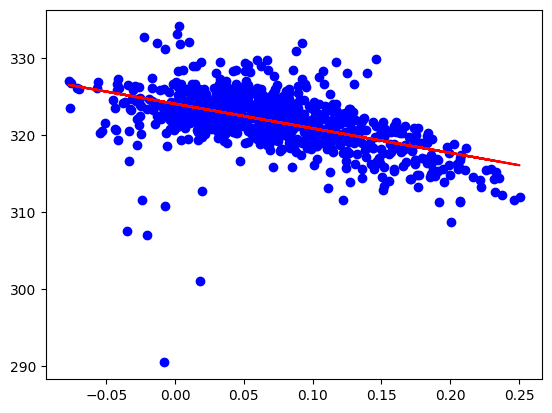

In [47]:
plt.plot(I_C.flatten(), T_C.flatten(), 'bo')
_ = plt.plot(I_C, I_C*a1 + a0, color='red')

<font size="2">**Sharpening**<font>
    
Generate a first estimate of the LST image at fine resolution. To do this define a function linear_sharpening

In [48]:
def linear_sharpening(index, slope, intercept):
    return index * slope + intercept

Plot this first estimate of LST map

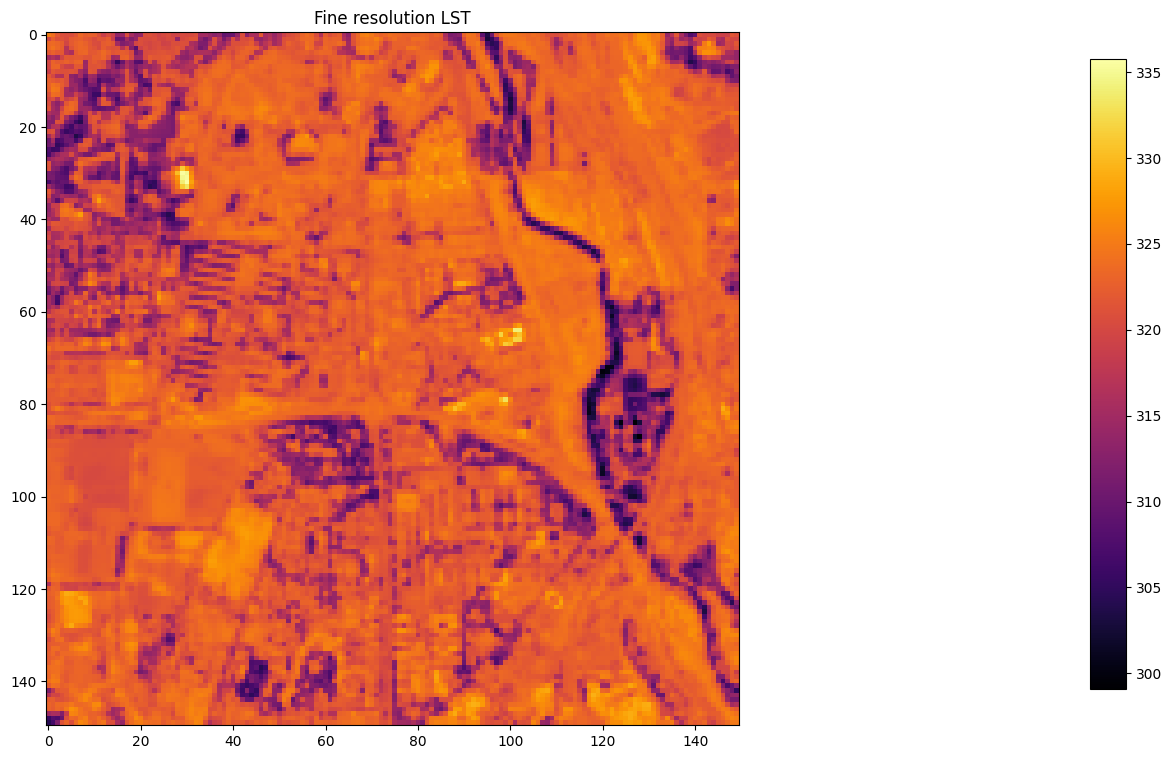

In [13]:
# T_sharp_temp = linear_sharpening(I_H, a1, a0)

fig, ax0 = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(18, 9))

ax0.set_title('Fine resolution LST')
img=ax0.imshow(linear_classed, cmap='inferno')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar=fig.colorbar(img, cax=cbar_ax)

plt.show()

<font size="2">**Residual Correction**<font>
    
Generate a final LST estimation by performing a residual correction on the precedent one. Write a function correction_linreg that provides the residual correction Delta_T_final

In [50]:
T_L_delta = T_C - (I_C * a1 + a0)
T_L_delta.shape

(30, 30)

In [ ]:
import numpy as np






In [55]:
coarse_residuals = T_C - (I_C * a1 + a0)

fine_residuals_linear = get_fine_residuals_linear(coarse_residuals)
fine_residuals_krig = get_fine_residuals_krig(coarse_residuals)

T_H_hat_linear = T_sharp_temp + fine_residuals_linear
T_H_hat_krig = T_sharp_temp + fine_residuals_krig

Plot together the coarse LST and the final fine scale LST

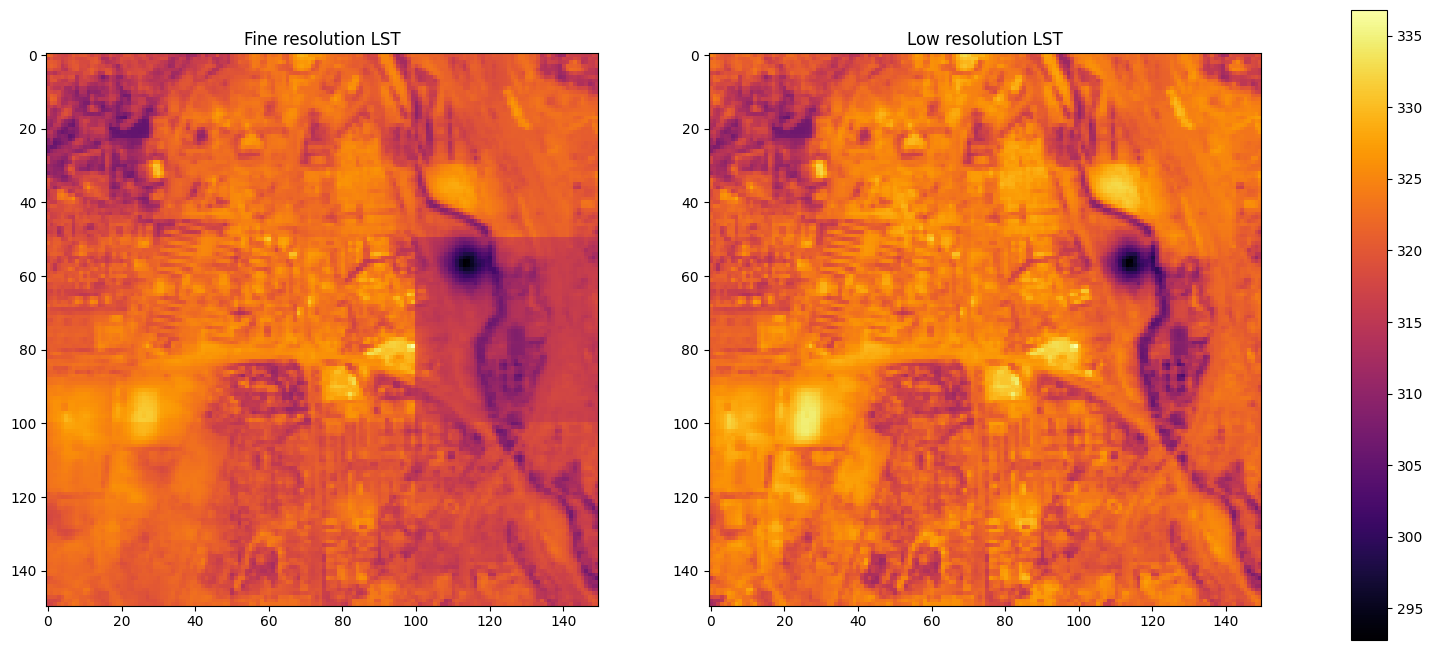

In [68]:
### TO DO
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(18, 9))

axs[0].set_title('Fine resolution LST')
img1=axs[0].imshow(reconstruct + fine_residuals_krig, cmap='inferno')

axs[1].set_title('Low resolution LST')
img2=axs[1].imshow(T_H_hat_krig, cmap='inferno')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar=fig.colorbar(img1, cax=cbar_ax)
cbar=fig.colorbar(img2, cax=cbar_ax)

plt.show()

Load the ground truth LST and compare it to the coarse scale LST the non corrected fine scale LST and the final product.

In [ ]:
path_temperature_h = 'data/LST_20m.img'

################### Temperature H ######################################

with rasterio.open(path_temperature_h) as dataset:
    T_H = dataset.read(1).astype(np.float32) 
    cols = dataset.width
    rows = dataset.height

# We can compute for example the RMSE

RMSE_GT_C = np.mean((T_C_resized - T_H) ** 2)
RMSE_GT_NC = np.mean((T_sharp_temp - T_H) ** 2)
rmse_linear = np.mean((T_H_hat_linear - T_H) ** 2)
rmse_krig = np.mean((T_H_hat_krig - T_H) ** 2)



print('RMSE with coarse scale', RMSE_GT_C)
print('RMSE with non corrected', RMSE_GT_NC)
print('RMSE with final product', rmse_linear)
print('RMSE with final product', rmse_krig)

RMSE with coarse scale 103573.2578543093
RMSE with non corrected 21.57698980437802
RMSE with final product 9.177208550747284
RMSE with final product 9.741766828649471


Plot the sharpened fine scale LST in function of the fine scale VI and the corresponding linear regression. Plot also the true fine scale LST in function of the fine scale VI and the coarse scale LST in function of the coarse scale VI.

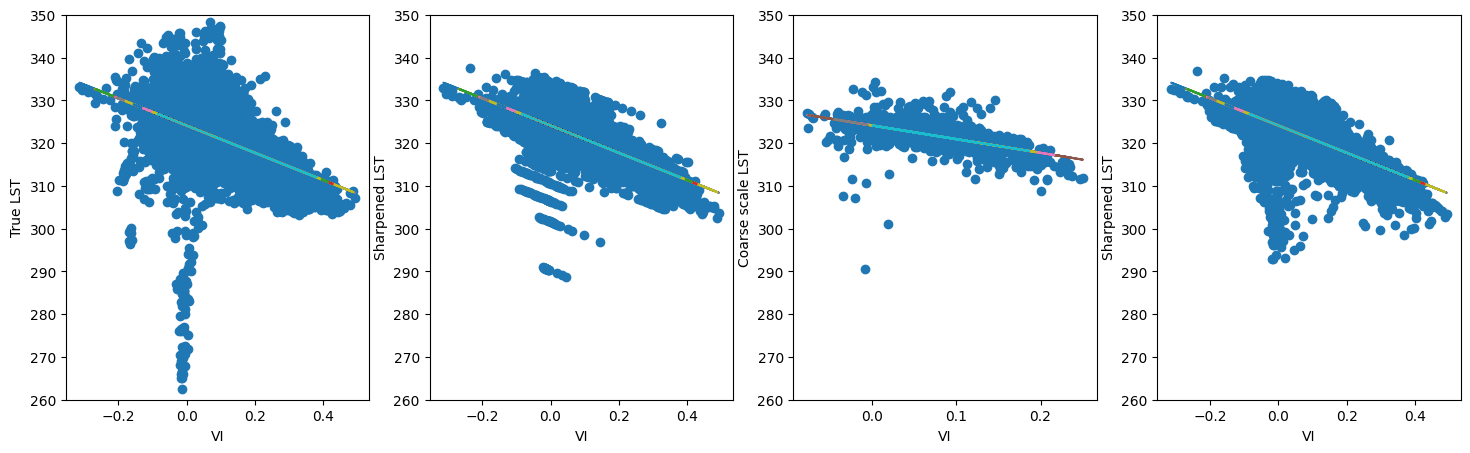

In [72]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharex=False, figsize=(18, 5))

### TO DO
ax0.scatter(I_H,T_H)
ax0.plot(I_H,a1*I_H+a0)
ax0.set_xlabel('VI')
ax0.set_ylabel('True LST')
ax0.set_ylim((260,350))

### TO DO
ax1.scatter(I_H,T_H_hat)
ax1.plot(I_H,a1*I_H+a0)
ax1.set_xlabel('VI')
ax1.set_ylabel('Sharpened LST')
ax1.set_ylim((260,350))

### TO DO
ax2.scatter(I_C,T_C)
ax2.plot(I_C,a1*I_C+a0)
ax2.set_xlabel('VI')
ax2.set_ylabel('Coarse scale LST')
ax2.set_ylim((260,350))

### TO DO
ax3.scatter(I_H,T_H_hat2)
ax3.plot(I_H,a1*I_H+a0)
ax3.set_xlabel('VI')
ax3.set_ylabel('Sharpened LST')
ax3.set_ylim((260,350))

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetResidual(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        out = self.final(d1)
        return out


In [41]:
import numpy as np
import math
from scipy.optimize import minimize

def round_to_nearest(value, step):
    return round(value / step) * step

def gamma_eta_eta(s, sill, range_):
    return sill * (1 - np.exp(-s / (range_ / 3)))

def empirical_gamma_L(s, xL_0_coord, delta_xL_0, xL_coords, delta_TL, s_tolerance=1e-3):
    N = len(xL_coords)
    distances = [
        np.linalg.norm(np.array(xL_0_coord) - np.array(xL_coord)) for xL_coord in xL_coords
    ]
    mask = np.abs(np.array(distances) - s) < s_tolerance

    sum_sq_diff = 0
    count = 0

    for i, is_distance in enumerate(mask):
        if is_distance:
            diff = delta_xL_0 - delta_TL[i]
            sum_sq_diff += diff ** 2
            count += 1

    if count == 0:
        return 0
    return sum_sq_diff / (2 * count)

def objective_sill_range(params, gamma_L_s, s_mm_s_arr, s_mm_0_arr, sigma_star):
    sill, range_ = params

    gamma_sum_s = np.sum([
        gamma_eta_eta(s_mm_s, sill, range_) for s_mm_s in s_mm_s_arr
      ])
    gamma_sum_0 = np.sum([
        gamma_eta_eta(s_mm_0, sill, range_) for s_mm_0 in s_mm_0_arr
    ])

    return (gamma_L_s - (1 / sigma_star) * (gamma_sum_s - gamma_sum_0)) ** 2

def compute_gamma_etaL(x_eta_coords, xL_fine_coords, sill, range_):
    sigma = len(xL_fine_coords)
    s_m = [np.linalg.norm(x_eta_coords - xLf) for xLf in xL_fine_coords]
    return (1 / sigma) * sum(gamma_eta_eta(s, sill, range_) for s in s_m)

def compute_gamma_LL(xL_i_fine_coords, xL_j_fine_coords, sill, range_):
    sigma = len(xL_i_fine_coords)
    gamma_sum = 0
    for m in range(sigma):
        for m1 in range(sigma):
            s = np.linalg.norm(xL_i_fine_coords[m] - xL_j_fine_coords[m1])
            gamma_sum += gamma_eta_eta(s, sill, range_)
    return gamma_sum / (sigma ** 2)

def solve_kriging_system(gamma_LL_matrix, gamma_etaL_vector):
    N = gamma_LL_matrix.shape[0]
    A = np.zeros((N + 1, N + 1))
    A[:N, :N] = gamma_LL_matrix
    A[:N, -1] = 1
    A[-1, :N] = 1
    A[-1, -1] = 0

    b = np.append(gamma_etaL_vector, 1)

    solution = np.linalg.solve(A, b)
    lambdas = solution[:-1]
    theta = solution[-1]
    return lambdas, theta


def get_high_res_pixels(coarse_pixel, high_res_image, scaling_factor=5):
    i, j = coarse_pixel

    high_res_block = high_res_image[
        i * scaling_factor : (i + 1) * scaling_factor,
        j * scaling_factor : (j + 1) * scaling_factor
    ]
    return high_res_block

def get_fine_pixels_from_coarse(coarse_pixel, scale = 5):
    i_c, j_c = coarse_pixel

    i_start = i_c * scale
    j_start = j_c * scale

    fine_pixels = [(i, j) for i in range(i_start, i_start + scale)
                          for j in range(j_start, j_start + scale)]
    return fine_pixels

def get_closest_pixels(image, pixel, N):
    i, j = pixel
    rows, cols = image.shape

    if i < 0 or i >= rows or j < 0 or j >= cols:
        raise ValueError("Pixel coordinates are out of bounds.")

    # Generate all possible pixel coordinates
    y_coords, x_coords = np.mgrid[0:rows, 0:cols]
    coordinates = np.column_stack((y_coords.ravel(), x_coords.ravel()))  # All (i,j) pairs

    # Compute Euclidean distances from the target pixel
    distances = np.sqrt((coordinates[:, 0] - i) ** 2 + (coordinates[:, 1] - j) ** 2)

    # Sort pixels by distance and get the first N
    sorted_indices = np.argsort(distances)
    closest_indices = sorted_indices[:N]
    closest_pixels = coordinates[closest_indices]

    # Get corresponding pixel values
    pixel_values = [image[y, x] for y, x in closest_pixels]

    return closest_pixels, pixel_values

def get_pixel_pairs_at_distance(coords, target_dist, tolerance=1e-3):
    pairs = []
    n = len(coords)
    for i in range(n):
        for j in range(n):
            if target_dist == 0:
                if i == j:
                    pairs.append((coords[i], coords[j]))
            elif i < j:  # avoid duplicates for non-zero distances
                dist = math.dist(coords[i], coords[j])
                if abs(dist - target_dist) <= tolerance:
                    pairs.append((coords[i], coords[j]))
    return pairs

In [42]:
T_H_hat.shape, T_C.shape

((150, 150), (30, 30))

In [54]:

empirical_gamma_Ls = {}
gamma_eta_eta_sills_and_ranges = {}


def get_s_distances(s, x_L_coords):
    res = get_pixel_pairs_at_distance(x_L_coords, s)
    distances = []
    for (x_L_i, x_L_j) in res:
      x_L_i_fine_pixels = get_fine_pixels_from_coarse(x_L_i)
      x_L_j_fine_pixels = get_fine_pixels_from_coarse(x_L_j)

      for m in x_L_i_fine_pixels:
        for m_ in x_L_j_fine_pixels:
          distances.append(
              np.linalg.norm(np.array(m) - np.array(m_))
          )
    return distances

def solve_for_sill_and_range(s_m, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta, sigma=5):
    gamma_L_s_m = get_gamma_L_s(s_m, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta.flatten())
    distances_s_mm  = get_s_distances(s_m, x_L_coords)
    distances_0_mm = get_s_distances(0, x_L_coords)

    sigma_star = len(distances_s_mm) * sigma ** 2

    min_res = minimize(
        lambda x: objective_sill_range(x, gamma_L_s_m, distances_s_mm, distances_0_mm, sigma_star),
        x0=(0.1, 0.1)
    )
    sill, range = min_res.x
    return sill, range


def calculate_gamma_eta_L(x_eta_coords, x_L_j_coords, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta):
    x_L_j_fine_pixels_coords = get_fine_pixels_from_coarse(x_L_j_coords)
    s_ms = [
        np.linalg.norm(x_eta_coords - np.array(x_L_j_coord))
        for x_L_j_coord in x_L_j_fine_pixels_coords
    ]
    sum = 0
    for s_m in s_ms:
       sum += get_gamma_eta_eta(s_m, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta)
    return sum

def get_gamma_L_s(s, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta):
    if s not in empirical_gamma_Ls:
        empirical_gamma_Ls[s] = empirical_gamma_L(s, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta)
    return empirical_gamma_Ls[s]

def get_gamma_eta_eta(s, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta):
    if s not in gamma_eta_eta_sills_and_ranges:
        gamma_eta_eta_sills_and_ranges[s] = solve_for_sill_and_range(s, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta)
    return gamma_eta_eta(s, *gamma_eta_eta_sills_and_ranges[s])
        

In [45]:
x_L_coords = [(i,j) for i in range(30) for j in range(30)]

x_L_0_coord = (0 ,0)
delta_x_L_0 = T_L_delta[x_L_0_coord]



x_L_i_coord = (0 ,0)
detla_x_L_i = T_L_delta[x_L_i_coord]

N = 25
n_closeset_coarse_coords, n_closest_coarse_values = get_closest_pixels(T_L_delta, x_L_i_coord, N)

fine_pixel_coords = get_fine_pixels_from_coarse(x_L_i_coord)
x_etas = [T_H_hat[i, j] for (i, j) in fine_pixel_coords]

In [46]:
x_eta_coords = fine_pixel_coords[0]
x_eta = T_H_hat[x_eta_coords]

In [ ]:
x_L_j_coords = n_closeset_coarse_coords[0]


In [55]:
res = calculate_gamma_eta_L(x_eta_coords, x_L_j_coords, x_L_0_coord, delta_x_L_0, x_L_coords, T_L_delta)

KeyboardInterrupt: 

In [ ]:

# z_fine is now your interpolated fine-resolution image
